In [2]:
#import main libraries
import requests
import json
from io import StringIO
import io
import pandas as pd
import folium

### Importing the files

In [3]:
#import the 6 files (2 per each experiment)
results1 = pd.read_csv("dataset/results/deployments_first_40p_10e_50d.csv", index_col=0)
results11 = pd.read_csv("dataset/results/deployments_second_40p_10e_50d.csv", index_col=0)
results2 = pd.read_csv("dataset/results/deployments_first_35p_30e_35d.csv", index_col=0)
results22 = pd.read_csv("dataset/results/deployments_second_35p_30e_35d.csv", index_col=0)
results3 = pd.read_csv("dataset/results/deployments_first_25p_25e_50d.csv", index_col=0)
results33 = pd.read_csv("dataset/results/deployments_second_25p_25e_50d.csv", index_col=0)
results4 = pd.read_csv("dataset/results/deployments_first_20p_60e_20d.csv", index_col=0)
results44 = pd.read_csv("dataset/results/deployments_second_20p_60e_20d.csv", index_col=0)
results44

,42 South Street,49 Beekman Street,100 Duane Street,14 N. Moore Street,75 Canal Street,25 Pitt Street,222 East 2 Street,340 East 14 Street,253 Lafayette Street,42 Great Jones Street,...,256 Hylan Blvd.,278 McClean Avenue,1850 Clove Road,1592 Richmond Road,256 Nelson Ave.,345 Annadale Road,1560 Drumgoole Road West,7219 Amboy Road,1100 Rossville Ave,305 Front Street
engine,1,1,2,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
ladder,1,0,2,0,1,2,1,1,1,1,...,1,1,1,0,2,1,1,1,0,0
rescue,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
squad,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
hazardous,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Comparing the df between the first and second shift

In [4]:
#prove a function to compare the vehicles configuration between two shifts
results1.compare(results11)

2282 Third Avenue       720 Melrose Ave.       1781 Monroe Ave.        \
                    self other             self other             self other   
engine               0.0   1.0              1.0   0.0              0.0   1.0   
ladder               1.0   0.0              0.0   1.0              1.0   0.0   

       2928 Briggs Ave.       1336 60th Street       126 Foster Ave.        
                   self other             self other            self other  
engine              1.0   0.0              1.0   0.0             0.0   1.0  
ladder              0.0   1.0              0.0   1.0             1.0   0.0

## QUESTION 1

In [5]:
#add a column for each dataset with the number of experiment to make easier future plots
results1['experiment'] = 1
results2['experiment'] = 2
results3['experiment'] = 3
results4['experiment'] = 4

#concatenate the datasets of the 1st shif in an unique df
results = pd.concat([results1, results2, results3, results4], keys=['results1', 'results2', 'results3', 'results4'])
results.reset_index(inplace=True)

#rename the columns of the df
results.rename(columns={'level_1': 'vehicle', 'level_0': 'results'}, inplace=True)

#change the df configuration
final = pd.melt(results, id_vars=['results', 'vehicle', 'experiment'], 
                    var_name='station', value_name='value')
print(final)

       results    vehicle  experiment           station  value
0     results1     engine           1   42 South Street      1
1     results1     ladder           1   42 South Street      1
2     results1     rescue           1   42 South Street      0
3     results1      squad           1   42 South Street      0
4     results1  hazardous           1   42 South Street      0
...        ...        ...         ...               ...    ...
4375  results4     engine           4  305 Front Street      1
4376  results4     ladder           4  305 Front Street      0
4377  results4     rescue           4  305 Front Street      0
4378  results4      squad           4  305 Front Street      0
4379  results4  hazardous           4  305 Front Street      0

[4380 rows x 5 columns]


In [6]:
#select the rows of stations with Ladder and Engine vehicles (value>0) for experiments 1 and 4 (first shift)
ladder_engine1 = final[(final.experiment==1) & (final.vehicle.isin(["engine", "ladder"])) & (final.value>0)]
ladder_engine4 = final[(final.experiment==4) & (final.vehicle.isin(["engine", "ladder"])) & (final.value>0)]
ladder_engine4

,results,vehicle,experiment,station,value
15,results4,engine,4,42 South Street,1
16,results4,ladder,4,42 South Street,1
35,results4,engine,4,49 Beekman Street,1
55,results4,engine,4,100 Duane Street,2
56,results4,ladder,4,100 Duane Street,2
...,...,...,...,...,...
4316,results4,ladder,4,1560 Drumgoole Road West,1
4335,results4,engine,4,7219 Amboy Road,1
4336,results4,ladder,4,7219 Amboy Road,1
4355,results4,engine,4,1100 Rossville Ave,1


In [7]:
#get coordinates of stations
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
json_response = json.loads(response.text)

### Map engine & ladder Experiment 1

In [8]:
from collections import defaultdict

#create a map
m1 = folium.Map(location=[40.70, -73.94], zoom_start=10, width="75%", tiles="CartoDB positron")

#establish colors for vehicle types
vehicle_colors = {
    "engine": 'darkblue',
    "ladder": 'lightred'}

#legend text and colors
legend_html = '''
<div style="position: fixed; bottom: 30px; right: 350px; z-index:1000; font-size:14px;">
     <p><strong>Legend</strong></p>
     <p><i class="fa fa-square fa-1x" style="color:darkblue;"></i> Engine</p>
     <p><i class="fa fa-square fa-1x" style="color:red;"></i> Ladder</p>

</div>
'''
#add the legend to the map
legend = folium.Element(legend_html)
m1.get_root().html.add_child(legend)

#iterate throught the rows of the df for experiment 1
for index, row in ladder_engine1.iterrows():
    facility_address = row['station']
    vehicle = row['vehicle']
    
    #find coordinates for the facility address from JSON data
    for feature in json_response['features']:
        if feature['properties']['FacilityAddress'] == facility_address:
            coordinates = feature['geometry']['coordinates']
            break
            
    #add a text for the point in the map
    popup_text = f"Vehicle: {vehicle}, Value: {row['value']}"
    #add the color for this point
    color = vehicle_colors[vehicle]
    
    #add the point to the map (vehicle)
    folium.Marker(
        location=coordinates[::-1],  # Reversed coordinates for Folium
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(m1)
    
#save the map in html
m1.save("html")

### Map engine & ladder Experiment 4

In [34]:
from collections import defaultdict

#create a map
m4 = folium.Map(location=[40.70, -73.94], zoom_start=10, width="75%", tiles="CartoDB positron")

#establish colors for vehicle types
vehicle_colors = {
    "engine": 'darkblue',
    "ladder": 'lightred'}

#legend text and colors
legend_html = '''
<div style="position: fixed; bottom: 30px; right: 350px; z-index:1000; font-size:14px;">
     <p><strong>Legend</strong></p>
     <p><i class="fa fa-square fa-1x" style="color:darkblue;"></i> Engine</p>
     <p><i class="fa fa-square fa-1x" style="color:red;"></i> Ladder</p>

</div>
'''
#add the legend to the map
legend = folium.Element(legend_html)
m4.get_root().html.add_child(legend)

#iterate throught the rows of the df for experiment 4
for index, row in ladder_engine4.iterrows():
    facility_address = row['station']
    vehicle = row['vehicle']
    
    #find coordinates for the facility address from JSON data
    for feature in json_response['features']:
        if feature['properties']['FacilityAddress'] == facility_address:
            coordinates = feature['geometry']['coordinates']
            break
            
    #add a text for the point in the map
    popup_text = f"Vehicle: {vehicle}, Value: {row['value']}"
    #add the color for this point
    color = vehicle_colors[vehicle]
    
    #add the point to the map (vehicle)
    folium.Marker(
        location=coordinates[::-1],  # Reversed coordinates for Folium
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(m4)

#save the map in html
m4.save("html2")

## QUESTION 2

In [10]:
#get the coordinates of stations
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
json_response = json.loads(response.text)

#select the rows of stations with Rescue and Squad vehicles (value>0) for all the experiments
final_squad = final[final.vehicle.isin(["squad"]) & (final.value>0)]
final_rescue = final[final.vehicle.isin(["rescue"]) & (final.value>0)]

### 2.1 Rescue 1st shift

In [38]:
from collections import defaultdict

#establish a color for each experiment
experiment_colors = {
    1: 'green',
    2: 'orange',
    3: 'purple',
    4: 'cadetblue'
}

#create a map
m = folium.Map(location=[40.70, -73.94], zoom_start=10, width="75%", tiles="CartoDB positron")

#legend text and colors
legend_html = '''
<div style="position: fixed; bottom: 10px; right: 350px; z-index:1000; font-size:14px;">
     <p><strong>Legend</strong></p>
     <p><i class="fa fa-square fa-1x" style="color:green;"></i> W<sub>p</sub>=0.40, W<sub>e</sub>=0.10, W<sub>d</sub>=0.50</p>
     <p><i class="fa fa-square fa-1x" style="color:orange;"></i> W<sub>p</sub>=0.35, W<sub>e</sub>=0.30, W<sub>d</sub>=0.35</p>
     <p><i class="fa fa-square fa-1x" style="color:purple;"></i> W<sub>p</sub>=0.25, W<sub>e</sub>=0.25, W<sub>d</sub>=0.50</p>
     <p><i class="fa fa-square fa-1x" style="color:cadetblue;"></i> W<sub>p</sub>=0.20, W<sub>e</sub>=0.60, W<sub>d</sub>=0.20</p>
     <p><i class="fa fa-square fa-1x" style="color:black;"></i> +2 coincidences</p>
</div>
'''

#add the legend to the map
legend = folium.Element(legend_html)
m.get_root().html.add_child(legend)

#store the coordinates and their occurrence count
coordinates_count = defaultdict(int)

#iterate throught the rows (stations with rescue vehicles) of the df for all experiments
for index, row in final_rescue.iterrows():
    facility_address = row['station']
    experiment = row['experiment']
    for feature in json_response['features']:
        if feature['properties']['FacilityAddress'] == facility_address:
            coordinates = feature['geometry']['coordinates']
            coordinates_tuple = tuple(coordinates)  #convert to tuple for hashing
            
            #count the occurrences of each coordinate
            coordinates_count[coordinates_tuple] += 1
    
    #add a text for the point in the map
    popup_text = f"Experiment: {experiment}, Value: {row['value']}"
    color = experiment_colors[experiment]
    
    #determine the color based on the count of occurrences at the coordinates
    if coordinates_count[coordinates_tuple] >= 2:
        color = 'black'
        
    #add the point to the map (vehicle)
    folium.Marker(
        location=coordinates[::-1],  # Reversed coordinates for Folium
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(m)

#save the map in html
m.save("html3")

## 2.2 Squad first shift

In [39]:
from collections import defaultdict

#establish a color for each experiment
experiment_colors = {
    1: 'green',
    2: 'orange',
    3: 'purple',
    4: 'lightblue'
}

#create a map
m = folium.Map(location=[40.70, -73.94], zoom_start=10, width="75%", tiles="CartoDB positron")

#legend text and colors
legend_html = '''
<div style="position: fixed; bottom: 10px; right: 350px; z-index:1000; font-size:14px;">
     <p><strong>Legend</strong></p>
     <p><i class="fa fa-square fa-1x" style="color:green;"></i> W<sub>p</sub>=0.40, W<sub>e</sub>=0.10, W<sub>d</sub>=0.50</p>
     <p><i class="fa fa-square fa-1x" style="color:orange;"></i> W<sub>p</sub>=0.35, W<sub>e</sub>=0.30, W<sub>d</sub>=0.35</p>
     <p><i class="fa fa-square fa-1x" style="color:purple;"></i> W<sub>p</sub>=0.25, W<sub>e</sub>=0.25, W<sub>d</sub>=0.50</p>
     <p><i class="fa fa-square fa-1x" style="color:lightblue;"></i> W<sub>p</sub>=0.20, W<sub>e</sub>=0.60, W<sub>d</sub>=0.20</p>
     <p><i class="fa fa-square fa-1x" style="color:black;"></i> +2 coincidences</p>
</div>
'''
#add the legend to the map
legend = folium.Element(legend_html)
m.get_root().html.add_child(legend)

#store the coordinates and their occurrence count
coordinates_count = defaultdict(int)

#iterate throught the rows (stations with squad vehicles) of the df for all experiments
for index, row in final_squad.iterrows():
    facility_address = row['station']
    experiment = row['experiment']
    for feature in json_response['features']:
        if feature['properties']['FacilityAddress'] == facility_address:
            coordinates = feature['geometry']['coordinates']
            coordinates_tuple = tuple(coordinates)  # Convert to tuple for hashing
            
            #count the occurrences of each coordinate
            coordinates_count[coordinates_tuple] += 1
    
    #add a text for the point in the map        
    popup_text = f"Experiment: {experiment}, Value: {row['value']}"
    color = experiment_colors[experiment]
    
    #determine the color based on the count of occurrences at the coordinates
    if coordinates_count[coordinates_tuple] >= 2:
        color = 'black'
        
    #add the point to the map (vehicle)
    folium.Marker(
        location=coordinates[::-1],  # Reversed coordinates for Folium
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(m)

#save the map to html
m.save("html4")

## QUESTION 3. All vehicles 1st shift

In [13]:
#prepare the df for question 3: sum the stations which has just 1 vehicle, 2 vehicles...
sum_q3 = final.groupby(['experiment', 'station'])['value'].sum().reset_index()
sum_q3

,experiment,station,value
0,1,10-40 47th Ave.,2
1,1,100 Duane Street,4
2,1,101-02 Jamaica Avenue,1
3,1,103-17 98th Street,1
4,1,104-12 Princeton Street,1
...,...,...,...
871,4,925 East Tremont Ave.,1
872,4,940 Dekalb Avenue,1
873,4,97-28 43rd Avenue,1
874,4,998 Liberty Ave.,1


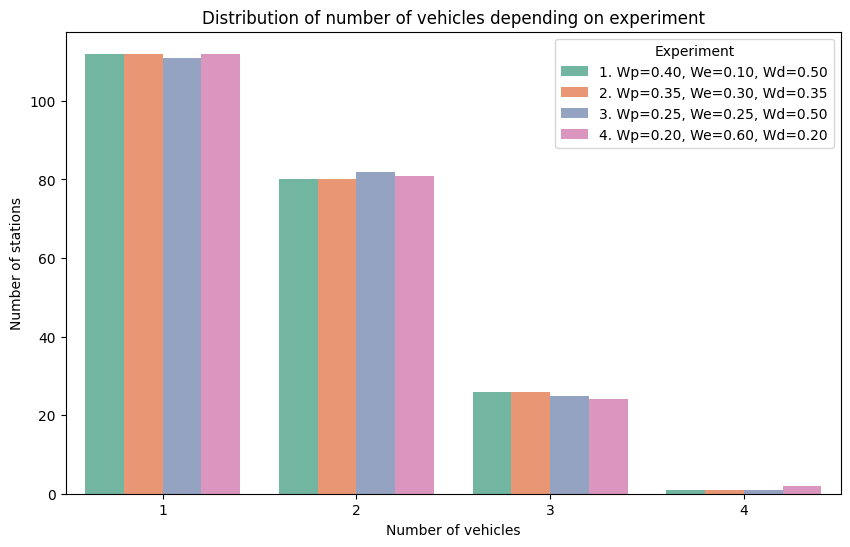

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

#create a barplot with the number of stations with 1 vehicle, 2 vehicles...
plt.figure(figsize=(10, 6))
sns.countplot(sum_q3, x="value", hue="experiment", palette="Set2") #color the barplot with the experiment
plt.title("Distribution of number of vehicles depending on experiment")

#change the legend 
plt.legend(title='Experiment', labels=['1. Wp=0.40, We=0.10, Wd=0.50', 
                                       '2. Wp=0.35, We=0.30, Wd=0.35', 
                                       '3. Wp=0.25, We=0.25, Wd=0.50',
                                       '4. Wp=0.20, We=0.60, Wd=0.20'])  # Adjust labels as needed
plt.xlabel("Number of vehicles")
plt.ylabel("Number of stations")

plt.show()

## QUESTION 4

### 4.1 Plot for experiment 1 comparing shifts 1 and 2

In [15]:
#add a column for each dataset with the number of experiment to make easier future plots
results11['experiment'] = 1
results44['experiment'] = 4

In [31]:
#compare results of experiment 1 between shifts and keep equal entries
a = results1.compare(results11, keep_equal=True)

#extract and reset indices for comparison of 'engine' data
a_engine = a.iloc[0].reset_index()

#extract and reset indices for comparison of 'ladder' data
a_ladder = a.iloc[1].reset_index()

#calculate the difference in 'engine' data between the shifts
diff_engine1 = (
    #merge 'self' and 'other' data on the same 'level_0' index
    a_engine[a_engine['level_1'] == 'self'].merge(
        a_engine[a_engine['level_1'] == 'other'],
        on='level_0',
        suffixes=('_self', '_other')
    )
    #filter and count unequal 'engine' values, sum the occurrences
    .query('engine_self != engine_other')['level_0'].value_counts().sum()
)

#calculate the difference in 'ladder' data between the shifts
diff_ladder1 = (
    # Merge 'self' and 'other' data on the same 'level_0' index
    a_ladder[a_ladder['level_1'] == 'self'].merge(
        a_ladder[a_ladder['level_1'] == 'other'],
        on='level_0',
        suffixes=('_self', '_other')
    )
    #filter and count unequal 'ladder' values, sum the occurrences
    .query('ladder_self != ladder_other')['level_0'].value_counts().sum()
)


### 4.2 Plot for experiment 4 comparing shifts 1 and 2

In [32]:
#compare results of experiment 4 between shifts and keep equal entries
b = results4.compare(results44, keep_equal=True)

#extract and reset indices for comparison of 'engine' data
b_engine = b.iloc[0].reset_index()
#extract and reset indices for comparison of 'ladder' data
b_ladder = b.iloc[1].reset_index()
#extract and reset indices for comparison of 'rescue' data
b_rescue = b.iloc[2].reset_index()
#extract and reset indices for comparison of 'squad' data
b_squad = b.iloc[3].reset_index()

#calculate the difference in 'engine' data between the shifts
diff_engine4 = b_engine[b_engine['level_1'] == 'self'].merge(
    b_engine[b_engine['level_1'] == 'other'], on='level_0', suffixes=('_self', '_other')
).query('engine_self != engine_other')['level_0'].value_counts().sum()

#calculate the difference in 'ladder' data between the shifts
diff_ladder4 = b_ladder[b_ladder['level_1'] == 'self'].merge(
    b_ladder[b_ladder['level_1'] == 'other'], on='level_0', suffixes=('_self', '_other')
).query('ladder_self != ladder_other')['level_0'].value_counts().sum()

#calculate the difference in 'rescue' data between the shifts
diff_rescue4 = b_rescue[b_rescue['level_1'] == 'self'].merge(
    b_rescue[b_rescue['level_1'] == 'other'], on='level_0', suffixes=('_self', '_other')
).query('rescue_self != rescue_other')['level_0'].value_counts().sum()

#calculate the difference in 'squad' data between the shifts
diff_squad4 = b_squad[b_squad['level_1'] == 'self'].merge(
    b_squad[b_squad['level_1'] == 'other'], on='level_0', suffixes=('_self', '_other')
).query('squad_self != squad_other')['level_0'].value_counts().sum()

In [18]:
#create a dataframe with 3 columns; experiment, vehicle type and differences between shifts
q4 = pd.DataFrame({"experiment": [1,1,1,1,4,4,4,4], "vehicle": ["engine", "ladder", "rescue", "squad", "engine", "ladder", "rescue", "squad"],
                  "diff": [diff_engine1, diff_ladder1, 0, 0, diff_engine4, diff_ladder4, diff_rescue4, diff_squad4]})
q4

,experiment,vehicle,diff
0,1,engine,6
1,1,ladder,6
2,1,rescue,0
3,1,squad,0
4,4,engine,20
5,4,ladder,38
6,4,rescue,4
7,4,squad,14


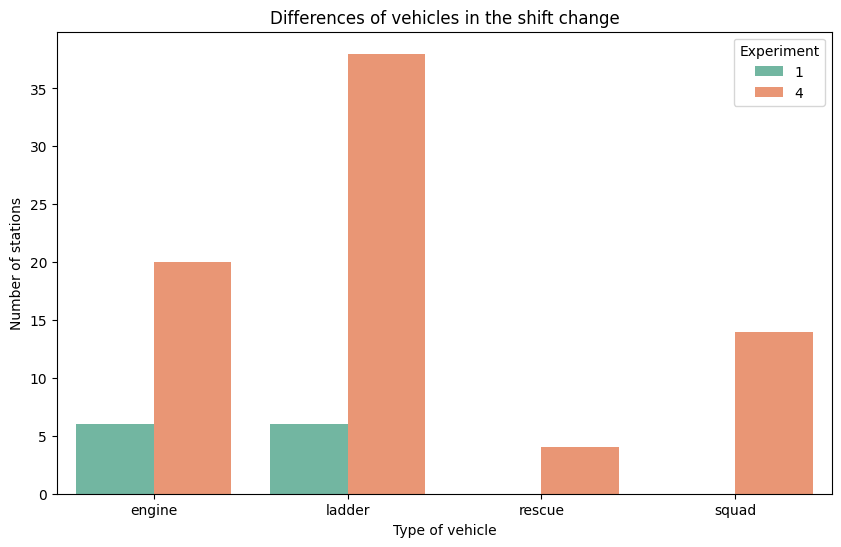

In [19]:
#plot with the different of vehicles in the shift change for experiments 1 and 4
plt.figure(figsize=(10, 6))
sns.barplot(x='vehicle', y='diff', hue='experiment', data=q4, palette="Set2")
plt.xlabel('Type of vehicle')
plt.ylabel('Number of stations')
plt.title('Differences of vehicles in the shift change')
plt.legend(title='Experiment')
plt.show()

# OTHER VISUALISATIONS (NOT INCLUDED IN THE REPORT)

## General map per each weights configuration (experiment)

In [20]:
def create_map(wp, we, wd, shift):
    #data needed
    results = pd.read_csv("dataset/results/deployments_"+str(shift)+"_"+str(int(wp*100)) + "p_" + str(int(we*100)) + "e_" + str(int(wd*100)) + "d.csv", index_col=0)
    response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
    json_response = json.loads(response.text)
    
    #creating map
    map = folium.Map(location=[40.70, -73.94], zoom_start=10, width="75%", tiles="CartoDB positron")
    vehicle_colors = {
        'engine': 'blue',
        'ladder': 'red',
        'rescue': 'green',
        'squad': 'orange',
        'hazardous': 'purple'
    }

    #Legend text
    legend_html = '''
    <div style="position: fixed; bottom: 50px; right: 50px; z-index:1000; font-size:14px;">
         <p><strong>Legend</strong></p>
         <p><i class="fa fa-square fa-1x" style="color:blue;"></i> Engine</p>
         <p><i class="fa fa-square fa-1x" style="color:red;"></i> Ladder</p>
         <p><i class="fa fa-square fa-1x" style="color:green;"></i> Rescue</p>
         <p><i class="fa fa-square fa-1x" style="color:orange;"></i> Squad</p>
         <p><i class="fa fa-square fa-1x" style="color:purple;"></i> Hazardous</p>
         <p><i class="fa fa-star fa-1x" style="color:black;"></i> +1 vehicle</p>
    </div>
    '''

    legend = folium.Element(legend_html)
    map.get_root().html.add_child(legend)

    #Adding markers to the map for each station
    for idx, polygon in enumerate(json_response["features"]):
        facility_address = polygon["properties"]["FacilityAddress"]
        coordinates = [polygon["geometry"]["coordinates"][1], polygon["geometry"]["coordinates"][0]]

        for vehicle_type in results.index:
            #Check if the station has just one unit of vehicle i
            if results.loc[vehicle_type, facility_address] > 0 and results.loc[vehicle_type, facility_address]<=1:
                color = vehicle_colors[vehicle_type]
                marker = folium.Marker(coordinates, tooltip=f"<b>Location</b>: {facility_address}", icon=folium.Icon(color=color))
                marker.add_to(map)

            #Check if the station has more than one unit of vehicle i   
            elif results.loc[vehicle_type, facility_address] > 1:
                color = vehicle_colors[vehicle_type]
                marker = folium.Marker(coordinates, tooltip=f"<b>Location</b>: {facility_address}", icon=folium.Icon(color=color, icon="star"))
                marker.add_to(map)
    return map

In [21]:
create_map(0.40, 0.10, 0.50, "first")

In [22]:
create_map(0.20, 0.60, 0.20, "first")

In [23]:
create_map(0.20, 0.60, 0.20, "second")

In [24]:
import matplotlib.pyplot as plt
def where_vehicle(wp, we, wd, shift, vehicle):
    #data needed
    results = pd.read_csv("dataset/results/deployments_"+str(shift)+"_"+str(int(wp*100)) + "p_" + str(int(we*100)) + "e_" + str(int(wd*100)) + "d.csv", index_col=0)
    results_t = results.transpose().reset_index()
    results_t['total_sum'] = results_t[['engine', 'ladder', 'rescue', 'squad', 'hazardous']].sum(axis=1)
    
    print(f"{vehicle} is allocated: {results_t.loc[results_t[vehicle] == 1, 'index'].tolist()}")

In [25]:
print('\nHAZMAT', "\n", "-"*20)
where_vehicle(0.40, 0.10, 0.50, "first", "hazardous")
where_vehicle(0.35, 0.30, 0.35, "first", "hazardous")
where_vehicle(0.25, 0.25, 0.50, "first", "hazardous")

print('\nSQUAD', "\n", "-"*20)
where_vehicle(0.40, 0.10, 0.50, "first", "squad")
where_vehicle(0.35, 0.30, 0.35, "first", "squad")
where_vehicle(0.25, 0.25, 0.50, "first", "squad")
where_vehicle(0.20, 0.60, 0.20, "first", "squad")

print('\nRESCUE', "\n", "-"*20)
where_vehicle(0.40, 0.10, 0.50, "first", "rescue")
where_vehicle(0.35, 0.30, 0.35, "first", "rescue")
where_vehicle(0.25, 0.25, 0.50, "first", "rescue")
where_vehicle(0.20, 0.60, 0.20, "first", "rescue")


HAZMAT 
 --------------------
hazardous is allocated: ['108-01 Horace Harding Exp.']
hazardous is allocated: ['108-01 Horace Harding Exp.']
hazardous is allocated: ['108-01 Horace Harding Exp.']

SQUAD 
 --------------------
squad is allocated: ['1901 Sedgwick Ave.', '169 Schofield Street', '5105 Snyder Ave.', '64-18 Queens Blvd.', '91-04 197th Street', '16-15, 16-17, 16-19 Central Ave.', '14 Brighton Avenue', '256 Nelson Ave.']
squad is allocated: ['242 East 111 Street', '3431 White Plains Road', '187 Union Ave.', '1635 E. 14th Street', '104-12 Princeton Street', '16-15, 16-17, 16-19 Central Ave.', '14 Brighton Avenue', '256 Nelson Ave.']
squad is allocated: ['242 East 111 Street', '3431 White Plains Road', '107 Watkins Street', '2429 86th Street', '61-20 Utopia Parkway', '48-06 Rockaway Beach Blvd', '14 Brighton Avenue', '256 Nelson Ave.']
squad is allocated: ['340 East 14 Street', '248 West 143 Street', '3446 Eastchester Road', '107 Watkins Street', '1157 79th St.', '61-20 Utopia P

In [26]:
where_vehicle(0.40, 0.10, 0.50, "second", "hazardous")
where_vehicle(0.35, 0.30, 0.35, "second", "hazardous")
where_vehicle(0.25, 0.25, 0.50, "second", "hazardous")
where_vehicle(0.20, 0.60, 0.20, "second", "hazardous")

hazardous is allocated: ['108-01 Horace Harding Exp.']
hazardous is allocated: ['108-01 Horace Harding Exp.']
hazardous is allocated: ['108-01 Horace Harding Exp.']
hazardous is allocated: ['108-01 Horace Harding Exp.']


In [27]:
def differences(wp, we, wd, shift):
    #data needed
    results = pd.read_csv("dataset/results/deployments_"+str(shift)+"_"+str(int(wp*100)) + "p_" + str(int(we*100)) + "e_" + str(int(wd*100)) + "d.csv", index_col=0)
    results_t = results.transpose().reset_index()
    results_t['total_sum'] = results_t[['engine', 'ladder', 'rescue', 'squad', 'hazardous']].sum(axis=1)
    
    response2 = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
    json_response2 = json.loads(response2.text)
    df_capacity = pd.DataFrame([
    {'index': feature['properties']['FacilityAddress'], 'capacity': feature['properties']['capacity']}
    for feature in json_response2['features']])
    
        
    data_bar = results_t.merge(df_capacity, how='left', on='index').sort_values(by="total_sum", ascending=False)
    filtered_data = data_bar[abs(data_bar['total_sum'] - data_bar['capacity']) >= 2].sort_values(by="capacity", ascending=False)

    # Creating the bar plot for the filtered data
    plt.figure(figsize=(8, 10))
    plt.scatter(filtered_data['index'], filtered_data['total_sum'], color='skyblue')

    # Adding red points for 'capacity' where 'total_sum' and 'capacity' differ
    plt.scatter(filtered_data['index'], filtered_data['capacity'], color='green')

    # Labeling and rotating x-axis ticks for better readability
    plt.xticks(rotation=90)
    plt.xlabel('Station Address')
    plt.ylabel('Number of vehicles')
    plt.title(f'Number of vehicles assigned in comparison to the station capacity (wp={wp}, we={we}, wd={wd})')
    plt.legend(['Assigned', 'Capacity'])

    # Displaying the plot
    plt.tight_layout()
    plt.show()
    
    total = abs(data_bar['total_sum'] - data_bar['capacity']).sum()
    print('TOTAL DIFFERENCES:', total)


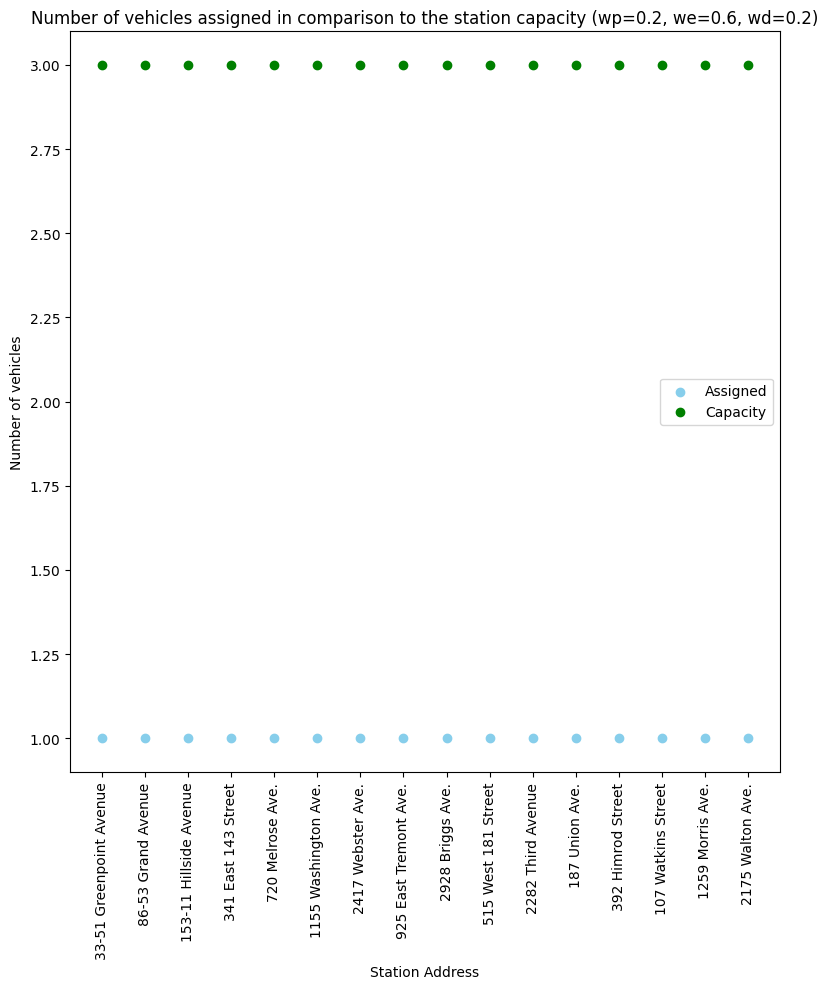

TOTAL DIFFERENCES: 66


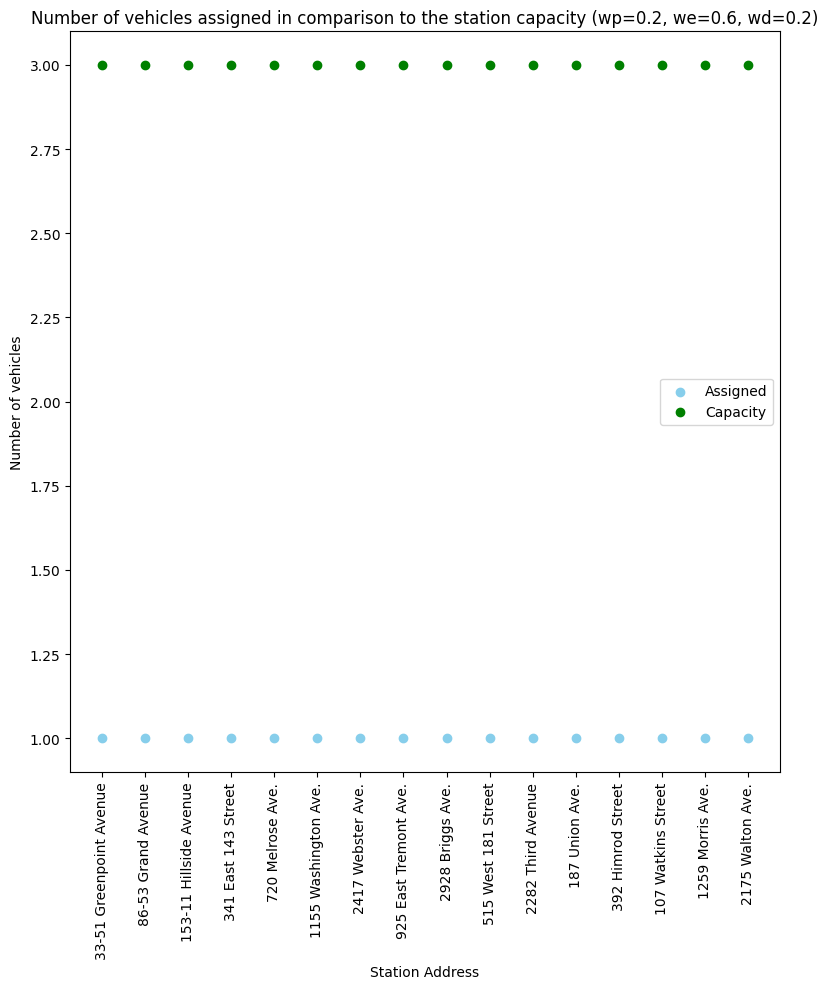

TOTAL DIFFERENCES: 66


In [28]:
#differences(0.40, 0.10, 0.50, "first")
#differences(0.35, 0.30, 0.35, "first")
#differences(0.25, 0.25, 0.50, "first")

differences(0.20, 0.60, 0.20, "first")

differences(0.20, 0.60, 0.20, "second")

## Analysing rescue & squad vehicles

In [29]:
def map2(wp, we, wd, shift):
    #data needed
    results = pd.read_csv("dataset/results/deployments_"+str(shift)+"_"+str(int(wp*100)) + "p_" + str(int(we*100)) + "e_" + str(int(wd*100)) + "d.csv", index_col=0)
    results = results.iloc[[2,3,4]] #selecting rescue, hazmat and squad vehicles
    response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
    
    json_response = json.loads(response.text)
    
    #creating map
    map = folium.Map(location=[40.70, -73.94], zoom_start=10, width="75%", tiles="CartoDB positron")
    vehicle_colors = {
        'rescue': 'green',
        'squad': 'orange',
        'hazardous': 'purple'
    }

    #Legend text
    legend_html = '''
    <div style="position: fixed; bottom: 30px; right: 250px; z-index:1000; font-size:14px;">
         <p><strong>Legend</strong></p>
         <p><i class="fa fa-square fa-1x" style="color:green;"></i> Rescue</p>
         <p><i class="fa fa-square fa-1x" style="color:orange;"></i> Squad</p>
         <p><i class="fa fa-square fa-1x" style="color:purple;"></i> Hazardous</p>
         <p><i class="fa fa-star fa-1x" style="color:black;"></i> +1 vehicle</p>
    </div>
    '''

    legend = folium.Element(legend_html)
    map.get_root().html.add_child(legend)

    #Adding markers to the map for each station
    for idx, polygon in enumerate(json_response["features"]):
        facility_address = polygon["properties"]["FacilityAddress"]
        coordinates = [polygon["geometry"]["coordinates"][1], polygon["geometry"]["coordinates"][0]]

        for vehicle_type in results.index:
            #Check if the station has just one unit of vehicle i
            if results.loc[vehicle_type, facility_address] > 0 and results.loc[vehicle_type, facility_address]<=1:
                color = vehicle_colors[vehicle_type]
                marker = folium.Marker(coordinates, tooltip=f"<b>Location</b>: {facility_address}", icon=folium.Icon(color=color))
                marker.add_to(map)

            #Check if the station has more than one unit of vehicle i   
            elif results.loc[vehicle_type, facility_address] > 1:
                color = vehicle_colors[vehicle_type]
                marker = folium.Marker(coordinates, tooltip=f"<b>Location</b>: {facility_address}", icon=folium.Icon(color=color, icon="star"))
                marker.add_to(map)
    return map

In [30]:
map22 = map2(0.40, 0.10, 0.50, "first")
#map22.save("scarce_vehicles.png")  # Save the map as a PNG file
map22